In [ ]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import cv2 as cv
import tensorflow as tf
import time
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
print('done')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
data_dir = "/content/drive/MyDrive/Colab Notebooks/new_dataset/bt_images/train"
data_dir = pathlib.Path(data_dir)
CLASS = np.array([item.name for item in data_dir.glob('*') if item.name != "/content/drive/MyDrive/Colab Notebooks/new_dataset/braintumor_categories.json"])
CLASS_NAMES=np.sort(CLASS,axis=0)
print(CLASS_NAMES)

['1' '2' '3' '4']


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE=64
IMG_HEIGHT=128
start = time.time()
#image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
data_dir = "/content/drive/MyDrive/Colab Notebooks/new_dataset/bt_images/train"
list_ds = tf.data.Dataset.list_files(str(data_dir+'/*/*'))
print(list_ds)
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES
def decode_img(img):
  print(img)
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  print(img)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  print(tf.image.resize(img, [IMG_HEIGHT, IMG_HEIGHT]))
  return tf.image.resize(img, [IMG_HEIGHT, IMG_HEIGHT])
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

train_ds = prepare_for_training(labeled_ds)

end=time.time()
print((end-start)*1000/60)

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("ReadFile:0", shape=(), dtype=string)
Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
Tensor("resize/Squeeze:0", shape=(128, 128, 3), dtype=float32)
173.5965092976888


In [ ]:
# load data for validation
val_dir = "/content/drive/MyDrive/Colab Notebooks/new_dataset/bt_images/test"
list_val_ds = tf.data.Dataset.list_files(str(val_dir+'/*/*'))
for f in list_val_ds.take(1):
  print(f.numpy())
labeled_val_ds = list_val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = prepare_for_training(labeled_val_ds)
print(val_ds)

b'/content/drive/MyDrive/Colab Notebooks/new_dataset/bt_images/test/4/no692.jpg'
Tensor("ReadFile:0", shape=(), dtype=string)
Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
Tensor("resize/Squeeze:0", shape=(128, 128, 3), dtype=float32)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.bool, name=None))>


In [ ]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (128, 128, 3)
Label:  [False False  True False]


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.bool, name=None))>


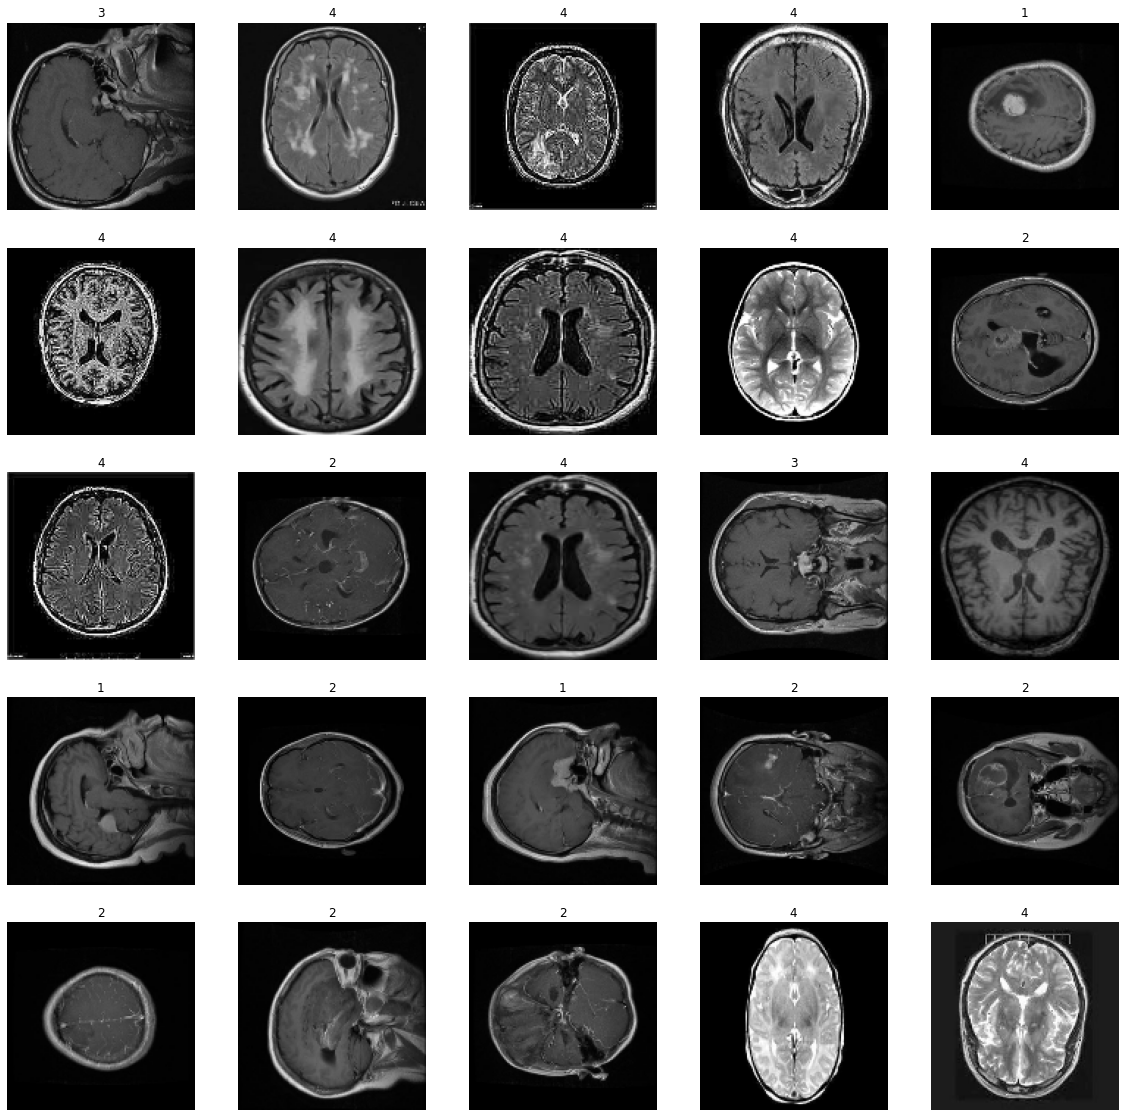

In [ ]:
train_ds = prepare_for_training(labeled_ds)
print(train_ds)
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
base_model = tf.keras.applications.Xception(input_shape=(128, 128, 3),
                                              include_top=False,
                                               weights='imagenet')

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 4, 4, 2048)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4,activation=tf.nn.softmax)
prediction_batch = prediction_layer(feature_batch_average)
drop_layer=tf.keras.layers.Dropout(0.5)
print(prediction_batch.shape)

(64, 4)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  drop_layer,
  global_average_layer,
  drop_layer,
  prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
logdir="logs1/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
history=model.fit(train_ds,steps_per_epoch=100,epochs=20,
                            validation_data=val_ds,validation_steps=100,callbacks=[tensorboard_callback])

Epoch 1/20
 20/100 [=====>........................] - ETA: 8:22 - loss: 0.4378 - accuracy: 0.8594

In [ ]:
!kill 12332

In [ ]:
import cv2

In [ ]:
filepath='/content/drive/MyDrive/Colab Notebooks/new_dataset/bt_images/test/2/2637.jpg'
import os
from PIL import Image

image = cv2.imread(filepath)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))
img = img.reshape(1, 128, 128, 3)
img = img.astype('float32')
img = img / 255.0
# print(img)
predictions = model.predict(img)
class_names = np.argmax(predictions)
print(class_names+1)

In [ ]:
import matplotlib.pyplot as plt

# Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Get training and test accuracy histories
training_accuracy = history.history['loss']
test_accuracy = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show()